In [346]:
import re

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from datasets import load_dataset

from nltk.tokenize.treebank import TreebankWordDetokenizer

from torch.nn.utils.rnn import pack_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
class QADataset(Dataset):
    def __init__(self, dataset, tokenizer, vocab, maxlen, special_tokens, device):
        super(QADataset, self).__init__()

        self.maxlen = maxlen
        self.special_tokens = special_tokens

        self.tokenizer = get_tokenizer('spacy') if tokenizer is None else tokenizer
        self.vocab = self.get_vocab(dataset) if vocab is None else vocab

        self.device = device

        sent1, sent2 = self.create_pair_dataset(dataset)

        self.sent1, self.lengths1 = self.get_tensor(sent1)
        self.sent2, self.lengths2 = self.get_tensor(sent2)

    def __getitem__(self, i):
        return self.sent1[i], self.lengths1[i], self.sent2[i], self.lengths2[i]

    def __len__(self):
        return len(self.sent1)

    def create_sentence_pairs(self, x):
        sentences = re.split(r'[\s]*#Person\d#: ', x['dialogue'])[1:]
        return {'sent1': sentences[:-1], 'sent2': sentences[1:]}

    def create_pair_dataset(self, dataset):
        dataset = dataset.map(self.create_sentence_pairs)

        flatten_sent1 = [sent for sents in dataset['sent1'] for sent in sents]
        flatten_sent2 = [sent for sents in dataset['sent2'] for sent in sents]

        df = pd.DataFrame({'sent1': flatten_sent1, 'sent2': flatten_sent2}).drop_duplicates()

        return df['sent1'].tolist(), df['sent2'].tolist()

    def tokenize_sent(self, sent):
        sent = ' '.join([self.special_tokens['bos_token'], sent, self.special_tokens['eos_token']])
        sent = [tok for tok in self.tokenizer(sent)]
        sent = sent[:self.maxlen]
        length = len(sent)
        sent = sent + [self.special_tokens['pad_token']] * (self.maxlen - len(sent))
        return sent, length

    def get_tensor(self, sents):
        tokens = torch.zeros((len(sents), self.maxlen), dtype=torch.long, device=self.device)
        lengths = []
        for i, sent in enumerate(sents):
            s, l = self.tokenize_sent(sent)
            tokens[i, :] = torch.tensor(self.vocab(s))
            lengths.append(l)

        return tokens, lengths

    def get_vocab(self, dataset):
        sent1, sent2 = self.create_pair_dataset(dataset)
        dataset = sent1 + sent2

        tokenized_dataset = list(map(lambda x: self.tokenize_sent(x)[0], dataset))

        vocab = build_vocab_from_iterator(tokenized_dataset, min_freq=5,
                                          specials=list(self.special_tokens.values()))
        vocab.set_default_index(vocab['|UNK|'])

        return vocab


In [ ]:
class EncoderModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, n_layers=32, n_hidden=128, dropout_rate=0.2):
        super(EncoderModel, self).__init__()

        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.dropout_rate = dropout_rate

        self.embed = nn.Embedding(self.vocab_size, embedding_dim=self.embed_dim)
        self.lstm = nn.LSTM(self.embed_dim, self.n_hidden, num_layers=self.n_layers, bidirectional=True,
                            batch_first=True)
        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, x, lengths=None):
        out = self.dropout(self.embed(x))

        if lengths is not None:
            out = pack_padded_sequence(out, lengths, batch_first=True, enforce_sorted=False)
        _, states = self.lstm(out)

        return states


class DecoderModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, n_layers=32, n_hidden=128, dropout_rate=0.2):
        super(DecoderModel, self).__init__()

        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.dropout_rate = dropout_rate

        self.embed = nn.Embedding(self.vocab_size, embedding_dim=self.embed_dim)
        self.lstm = nn.LSTM(self.embed_dim, self.n_hidden, num_layers=self.n_layers,
                            batch_first=True)
        self.fc = nn.Linear(self.n_hidden, self.vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, states, lengths=None):
        out = self.dropout(self.embed(x))
        if lengths is not None:
            out = pack_padded_sequence(out, lengths, batch_first=True, enforce_sorted=False)
        out, states = self.lstm(out, states)
        out = self.fc(out)
        out = self.softmax(out)

        return out, states


In [ ]:
def train_step(enc_model, dec_model, loader, enc_opt, dec_opt, criterion, device):
    enc_model.train(), dec_model.train()

    pbar = tqdm(loader)
    batch_losses = []

    for i, (x, len_x, y, len_y) in enumerate(pbar):
        x = x.to(device)
        y = y.to(device)

        enc_opt.zero_grad()
        dec_opt.zero_grad()

        enc_states = enc_model(x, len_x)
        dec_out, _ = dec_model(y[:, :-1], enc_states)

        loss = criterion(dec_out.moveaxis(1, -1), y[:, 1:])
        loss.backward()

        enc_opt.step()
        dec_opt.step()

        batch_losses.append(loss.item())
        pbar.set_description(f'Batch Loss: {loss.item():.3f} Train Loss: {np.mean(batch_losses):.3f}')

    return np.mean(batch_losses)


def eval_step(enc_model, dec_model, loader, criterion, device):
    enc_model.eval(), dec_model.eval()

    pbar = tqdm(loader)
    batch_losses = []

    with torch.no_grad():
        for i, (x, len_x, y, len_y) in enumerate(pbar):
            x = x.to(device)
            y = y.to(device)

            enc_states = enc_model(x, len_x)
            dec_out, _ = dec_model(y[:, :-1], enc_states)

            loss = criterion(dec_out.moveaxis(1, -1), y[:, 1:])

            batch_losses.append(loss.item())
            pbar.set_description(f'Batch Loss: {loss.item():.3f} Validation Loss: {np.mean(batch_losses):.3f}')

    return np.mean(batch_losses)


def beam_search(model, tokenized_sent, num_beams, max_new_token, eos_token_id, **kwargs):
    # generate function for beam search decoding
    # model: model to generate
    # tokenized_sent: tokenized input sentence
    # num_beams: number of beams
    # max_new_token: maximum number of new tokens to generate
    # eos_token_id: end of sentence token_id for early stopping
    # **kwargs: additional arguments for model forward pass

    # get first beams
    out, states = model(tokenized_sent, kwargs.get('states'))
    top_preds = out[-1, :].topk(num_beams, dim=-1)

    # add predictions to beams
    beams = [(pred.unsqueeze(0), states, score.item()) for pred, score in zip(top_preds.indices, top_preds.values)]

    for i in range(max_new_token - 1):
        new_beams = []
        for beam in beams:
            if beam[0][-1] == eos_token_id:
                new_beams.append(beam)
                continue

            out, states = model(beam[0][-1:], beam[1])
            top_preds = out[-1, :].topk(num_beams, dim=-1)

            for pred, score in zip(top_preds.indices, top_preds.values):
                new_beams.append((torch.cat((beam[0], pred.unsqueeze(0)), dim=0), states, beam[2] + score.item()))

        beams = sorted(new_beams, key=lambda x: x[2], reverse=True)[:num_beams]

        if beams[0][0][-1] == eos_token_id:
            break

    # return the best beam and its states
    return beams[0][0], beams[0][1]


def answer(enc_model, dec_model, sent, maxlen, tokenizer, vocab, special_tokens, device):
    enc_model.eval(), dec_model.eval()

    eos_token_id = vocab[special_tokens['eos_token']]
    detokenizer = TreebankWordDetokenizer()

    sent = ' '.join([special_tokens['bos_token'], sent, special_tokens['eos_token']])
    sent = [tok for tok in tokenizer(sent)]
    sent = torch.tensor(vocab(sent), device=device)
    print(sent)

    answer_sent = vocab([special_tokens['bos_token']])
    answer_sent = torch.tensor(answer_sent, device=device)
    print(answer_sent)

    with torch.no_grad():
        encoder_states = enc_model(sent)

        answer, _ = beam_search(dec_model, answer_sent, num_beams=1, max_new_token=maxlen, eos_token_id=eos_token_id, states=encoder_states)
        print(answer)
        tokens = vocab.lookup_tokens(answer.tolist())

        return detokenizer.detokenize(tokens)


In [349]:
def train(max_len, bs, lr, epochs, **kwargs):
    special_tokens = {'bos_token': '|BOS|',
                      'pad_token': '|PAD|',
                      'eos_token': '|EOS|',
                      'unk_token': '|UNK|'}

    train_dataset = load_dataset('knkarthick/dialogsum', split='train')
    val_dataset = load_dataset('knkarthick/dialogsum', split='validation')

    lm_train = QADataset(train_dataset, None, None, max_len, special_tokens, device)
    lm_valid = QADataset(val_dataset, lm_train.tokenizer, lm_train.vocab, max_len, special_tokens, device)

    train_loader = DataLoader(lm_train, batch_size=bs, shuffle=True)
    val_loader = DataLoader(lm_valid, batch_size=bs)

    encoder_kwargs = {k.replace('encoder_', ''): v for k, v in kwargs.items() if 'encoder_' in k}
    encoder_model = EncoderModel(vocab_size=len(lm_train.vocab), **encoder_kwargs).to(device)

    decoder_kwargs = {k.replace('decoder_', ''): v for k, v in kwargs.items() if 'decoder_' in k}
    decoder_model = DecoderModel(vocab_size=len(lm_train.vocab), **decoder_kwargs).to(device)

    #assert decoder_kwargs['n_layers'] == 2 * encoder_kwargs['n_layers'], '# of encoder layers must be the double the size of # decoder layers..'

    encoder_optimizer = optim.Adam(encoder_model.parameters(), lr=lr)
    decoder_optimizer = optim.Adam(decoder_model.parameters(), lr=lr)

    criterion = nn.NLLLoss()

    train_losses, val_losses = [], []
    for e in range(epochs):
        train_loss = train_step(encoder_model, decoder_model, train_loader,
                                encoder_optimizer, decoder_optimizer, criterion,
                                device)
        val_loss = eval_step(encoder_model, decoder_model,
                             val_loader, criterion, device)
        ans = answer(encoder_model, decoder_model, 'Hi, how are you?', max_len, lm_train.tokenizer, lm_train.vocab, special_tokens, device)
        print('ANSWER: ', ans)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        torch.save(encoder_model.state_dict(), f'encoder{e+1}.pt')
        torch.save(decoder_model.state_dict(), f'decoder{e+1}.pt')

    plt.plot(train_losses, 'r', label='Training Loss')
    plt.plot(val_losses, 'b', label='Validation Loss')
    plt.title('BiLSTM + LSTM Training Results')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('bilstm_results.png')

    return val_loss


In [350]:
max_len = 50
bs = 8
lr = 1e-3
epochs = 20
device = 'cuda'

In [354]:
torch.save(lm_train.vocab, 'bilstm_tokenizer.pth')

In [355]:
encoder_model = EncoderModel(vocab_size=len(lm_train.vocab), embed_dim=256 , n_layers=2, n_hidden=256, dropout_rate=0.2).to(device)
decoder_model = DecoderModel(vocab_size=len(lm_train.vocab), embed_dim=256, n_layers=4, n_hidden=256, dropout_rate=0.2).to(device)

torch.save(encoder_model.load_state_dict(torch.load('../saved models/bilstm_lstm-models/encoder8.pt')), 'encoder_model8.pt')
torch.save(decoder_model.load_state_dict(torch.load('../saved models/bilstm_lstm-models/decoder8.pt')), 'decoder_model8.pt')


In [360]:
special_tokens = {'bos_token': '|BOS|',
                      'pad_token': '|PAD|',
                      'eos_token': '|EOS|',
                      'unk_token': '|UNK|'}
answer(encoder_model, decoder_model, 'Hi, how are you?', 50, lm_train.tokenizer, lm_train.vocab, special_tokens, 'cuda')

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 276,   5, 392,   4,   2], device='cuda:0')


"I'm fine, thanks . |EOS|"

In [362]:
torch.save(encoder_model, 'encoder_model8.pt')
torch.save(decoder_model, 'decoder_model8.pt')


Using custom data configuration knkarthick--dialogsum-caf2f3e75d9073aa
Found cached dataset csv (/home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
Using custom data configuration knkarthick--dialogsum-caf2f3e75d9073aa
Found cached dataset csv (/home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
/home/sefa/anaconda3/envs/chat2learn/lib/python3.8/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(
Loading cached processed dataset at /home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-9d033395d0a367cf.arrow
Loading cached processed dataset at /home/sefa/

  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34,  79,  10,  19,  11, 674,   4,   2], device='cuda:0')
ANSWER:  I'm going to have a reservation . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([280,   5,   6,  34, 594,  10, 343,  20,   4,   2], device='cuda:0')
ANSWER:  Hi, I'm calling to hear that . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([280,   5,   6,  34, 594,  10, 283,   7,   4,   2], device='cuda:0')
ANSWER:  Hi, I'm calling to meet you . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([   6,   34,  276,    4,    6,   34,   79,   10,   19,   10,   54,   10,
           8, 1124,    4,    2], device='cuda:0')
ANSWER:  I'm fine . I'm going to have to go to the gym . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([564,   5, 392,   4,   6,  34,  71, 177,   4,   6,  34,  58, 260,  22,
         11, 134, 154,   4,   2], device='cuda:0')
ANSWER:  Fine, thanks . I'm very sorry . I'm just looking for a new job . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 276,   4,   6,  34,  58, 260,  22,  11, 134,  60,   4,   2],
       device='cuda:0')
ANSWER:  I'm fine . I'm just looking for a new one . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 276,   4,   6,  34, 594,  10, 283,   7,   4,   2],
       device='cuda:0')
ANSWER:  I'm fine . I'm calling to meet you . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([   6,   34,  276,    4,    6,   34,   79,   10,   19,   10,   53,   11,
         134, 1847,    4,    2], device='cuda:0')
ANSWER:  I'm fine . I'm going to have to get a new carpet . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([251,  86, 254,   4,   2], device='cuda:0')
ANSWER:  Not too bad . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 276,   4,   6,  34, 260,  22,  11, 134, 154,   4,   2],
       device='cuda:0')
ANSWER:  I'm fine . I'm looking for a new job . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 276,   4,   2], device='cuda:0')
ANSWER:  I'm fine . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([   6,   34,  276,    4,    6,   34,   79,   10,   19,   10,  464,   85,
          28, 2080,   80,    8, 1155, 1112,    4,    2], device='cuda:0')
ANSWER:  I'm fine . I'm going to have to pick up my aunt from the United States . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([   6,   34,  276,    4,    6,   34,   79,   10,   25,   11, 2604, 3057,
           4,    2], device='cuda:0')
ANSWER:  I'm fine . I'm going to be a senior engineer . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 276,   4,   6,  34,  79,  10,  19,  10, 464,  85,  65,  16,
         28, 323,   4,   2], device='cuda:0')
ANSWER:  I'm fine . I'm going to have to pick up some of my friends . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([ 280,    5,    6,   34, 2658,    4,    6,   34,   11,  176,  862,   38,
          13,    4,    2], device='cuda:0')
ANSWER:  Hi, I'm Henry . I'm a little worried about it . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([   6,   34,  276,    4,    6,   34,   79,   10,   25,   11, 2815,   17,
           8,  802,    4,    2], device='cuda:0')
ANSWER:  I'm fine . I'm going to be a volunteer in the library . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 276,   4,   6,  34, 260,  22,  11, 134, 154,   4,   2],
       device='cuda:0')
ANSWER:  I'm fine . I'm looking for a new job . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 276,   5, 392,   4,   2], device='cuda:0')
ANSWER:  I'm fine, thanks . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([   6,   34,  276,    4,    6,   34,   11,  176, 1082,    4,    2],
       device='cuda:0')
ANSWER:  I'm fine . I'm a little nervous . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([   6,   34,  276,    4,    6,   34,   58,  260,   22,   11, 1332,    4,
           2], device='cuda:0')
ANSWER:  I'm fine . I'm just looking for a coat . |EOS|


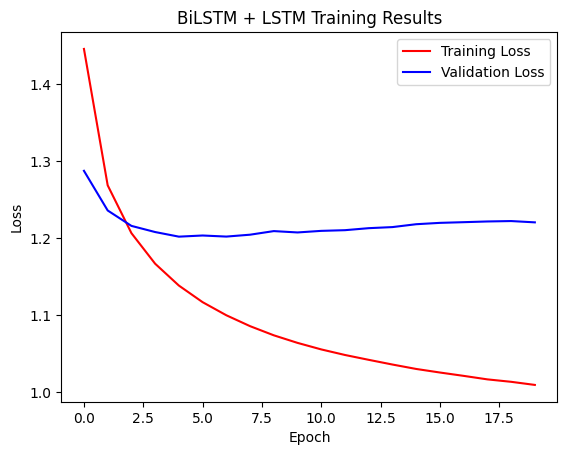

In [351]:
val_loss = train(max_len, bs, lr, epochs, device=device,
                 encoder_embed_dim=256, encoder_n_layers=1, encoder_n_hidden=256, encoder_dropout_rate=0.2,
                 decoder_embed_dim=256, decoder_n_layers=2, decoder_n_hidden=256, decoder_dropout_rate=0.2)

Using custom data configuration knkarthick--dialogsum-caf2f3e75d9073aa
Found cached dataset csv (/home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
Using custom data configuration knkarthick--dialogsum-caf2f3e75d9073aa
Found cached dataset csv (/home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
/home/sefa/anaconda3/envs/chat2learn/lib/python3.8/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(
Loading cached processed dataset at /home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-9d033395d0a367cf.arrow
Loading cached processed dataset at /home/sefa/

  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([ 40,   5,   6,  34,  52, 127,   4,   6,  34,  79,  10,  54,  10,   8,
        189,   4,   2], device='cuda:0')
ANSWER:  Yes, I'm not sure . I'm going to go to the company . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34,  52, 127,   4,   6,  34,  79,  10,  25,  11, 319, 319,   4,
          2], device='cuda:0')
ANSWER:  I'm not sure . I'm going to be a bit bit . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([564,   4,   6,  34, 260,  22,  11, 154,   4,   2], device='cuda:0')
ANSWER:  Fine . I'm looking for a job . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([564,   4,   6,  34, 260,  22,  11, 154,   4,   2], device='cuda:0')
ANSWER:  Fine . I'm looking for a job . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([564,   4,   6,  34, 594,  10, 283,   7,   4,   2], device='cuda:0')
ANSWER:  Fine . I'm calling to meet you . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([564,   5, 392,   4,   2], device='cuda:0')
ANSWER:  Fine, thanks . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 276,   4,   2], device='cuda:0')
ANSWER:  I'm fine . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 276,   5, 392,   4,   2], device='cuda:0')
ANSWER:  I'm fine, thanks . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 276,   5, 392,   4,   6,  34,  71, 423,   4,   2],
       device='cuda:0')
ANSWER:  I'm fine, thanks . I'm very busy . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([251, 254,   4,   6,  34, 459,   7,  31,  13,   4,   2],
       device='cuda:0')
ANSWER:  Not bad . I'm glad you like it . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([564,   5, 392,   4,   2], device='cuda:0')
ANSWER:  Fine, thanks . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([564,   4,   6,  34,  79,  10,  19,  11, 354,   4,   2],
       device='cuda:0')
ANSWER:  Fine . I'm going to have a party . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([251, 254,   4,   6,  34,  11, 134, 685,   4,   2], device='cuda:0')
ANSWER:  Not bad . I'm a new student . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 276,   4,   6,  34,  71, 423,   4,   2], device='cuda:0')
ANSWER:  I'm fine . I'm very busy . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([564,   5, 392,   4,   2], device='cuda:0')
ANSWER:  Fine, thanks . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([251, 254,   4,   6,  34,  58, 260,  22,  11, 134, 154,   4,   2],
       device='cuda:0')
ANSWER:  Not bad . I'm just looking for a new job . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([361,   4,   2], device='cuda:0')
ANSWER:  Great . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([ 251,  254,    4,    6,   34,   79,   10,    8, 1112,    4,    2],
       device='cuda:0')
ANSWER:  Not bad . I'm going to the States . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([251, 254,   4,   6,  34,  79,  10, 476,  28, 684,   4,   2],
       device='cuda:0')
ANSWER:  Not bad . I'm going to visit my sister . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 276,   4,   2], device='cuda:0')
ANSWER:  I'm fine . |EOS|


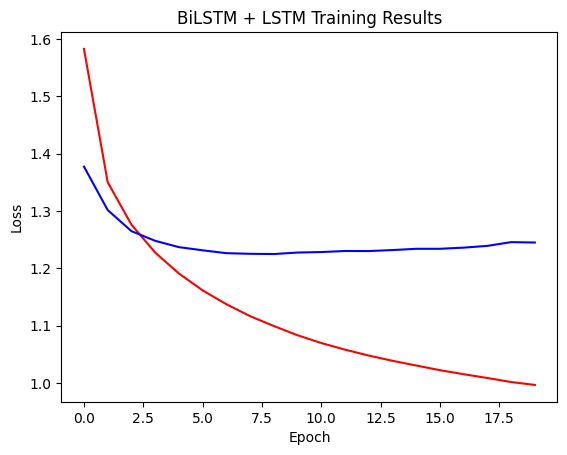

In [348]:
val_loss = train(max_len, bs, lr, epochs, device=device,
                 encoder_embed_dim=256, encoder_n_layers=2, encoder_n_hidden=256, encoder_dropout_rate=0.2,
                 decoder_embed_dim=256, decoder_n_layers=4, decoder_n_hidden=256, decoder_dropout_rate=0.2)

In [340]:
#df = pd.DataFrame()

for lr in [1e-2]:
    for t in range(3):
        val_loss = train(max_len, bs, lr, epochs, device=device,
                         encoder_embed_dim=128, encoder_n_layers=1, encoder_n_hidden=128, encoder_dropout_rate=0.2,
                         decoder_embed_dim=128, decoder_n_layers=2, decoder_n_hidden=128, decoder_dropout_rate=0.2)

        df.at[f'Learning Rate {lr}', f'Trial {t+1}'] = val_loss

m = df.mean(axis=1)
s = df.std(axis=1)

df['Mean'] = m
df['Std'] = s

df

Using custom data configuration knkarthick--dialogsum-caf2f3e75d9073aa
Found cached dataset csv (/home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
Using custom data configuration knkarthick--dialogsum-caf2f3e75d9073aa
Found cached dataset csv (/home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
/home/sefa/anaconda3/envs/chat2learn/lib/python3.8/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(
Loading cached processed dataset at /home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-9d033395d0a367cf.arrow
Loading cached processed dataset at /home/sefa/

  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34,  52, 127,   4,   2], device='cuda:0')
ANSWER:  I'm not sure . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 177,   5,  42,   6,  34, 177,   5,   6,  34, 177,   5,   6,
         34, 177,   5,   6,  34, 177,   5,   6,  34, 177,   5,   6,  34, 177,
          5,   6,  34, 177,   5,   6,  34, 177,   5,   6,  34, 177,   5,   6,
         34, 177,   5,   6,  34, 177,   5,   6], device='cuda:0')
ANSWER:  I'm sorry, but I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 177,   5,  42,   6,  34, 177,  10, 343,  20,   4,   2],
       device='cuda:0')
ANSWER:  I'm sorry, but I'm sorry to hear that . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34,  52, 127,   4,   2], device='cuda:0')
ANSWER:  I'm not sure . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 177,   4,   6,  34, 177,   4,   2], device='cuda:0')
ANSWER:  I'm sorry . I'm sorry . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 177,   4,   6,  34,  52, 127,   4,   2], device='cuda:0')
ANSWER:  I'm sorry . I'm not sure . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 273,   6,  34,  79,  10,  25,  11,  67, 221,   4,   2],
       device='cuda:0')
ANSWER:  I'm afraid I'm going to be a good idea . |EOS|


Using custom data configuration knkarthick--dialogsum-caf2f3e75d9073aa
Found cached dataset csv (/home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
Using custom data configuration knkarthick--dialogsum-caf2f3e75d9073aa
Found cached dataset csv (/home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
/home/sefa/anaconda3/envs/chat2learn/lib/python3.8/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(
Loading cached processed dataset at /home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-9d033395d0a367cf.arrow
Loading cached processed dataset at /home/sefa/

  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 177,   4,   6,  34,  52, 127,   7,  87,  52,  11,  67, 221,
          4,   2], device='cuda:0')
ANSWER:  I'm sorry . I'm not sure you're not a good idea . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 177,   4,   2], device='cuda:0')
ANSWER:  I'm sorry . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34,  52, 127,   4,   2], device='cuda:0')
ANSWER:  I'm not sure . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34,  52,  79,  10,  53,  11, 120,  16, 183,   4,   2],
       device='cuda:0')
ANSWER:  I'm not going to get a lot of money . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34,  52, 127,   4,   2], device='cuda:0')
ANSWER:  I'm not sure . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  18,  21,  49,   4,   6,  44,  19,  10,  54,  10,   8, 783,   4,
          2], device='cuda:0')
ANSWER:  I don't know . I'll have to go to the airport . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34,  52,  11, 176, 319, 127,   4,   2], device='cuda:0')
ANSWER:  I'm not a little bit sure . |EOS|


Using custom data configuration knkarthick--dialogsum-caf2f3e75d9073aa
Found cached dataset csv (/home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
Using custom data configuration knkarthick--dialogsum-caf2f3e75d9073aa
Found cached dataset csv (/home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
Loading cached processed dataset at /home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-9d033395d0a367cf.arrow
Loading cached processed dataset at /home/sefa/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-caf2f3e75d9073aa/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-a45bb773a7c0cad2.arrow
Loading ca

  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([ 40,   5,   6,  34,  79,  10,  25,  11, 120,  16,   4,   2],
       device='cuda:0')
ANSWER:  Yes, I'm going to be a lot of . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 177,   4,   6,  44,  25, 385,  10,  25,  11, 120,  16, 112,
          4,   2], device='cuda:0')
ANSWER:  I'm sorry . I'll be able to be a lot of people . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 177,  10, 343,  20,   4,   2], device='cuda:0')
ANSWER:  I'm sorry to hear that . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([  6,  34, 177,   4,   6,  34,  52, 127,   4,   2], device='cuda:0')
ANSWER:  I'm sorry . I'm not sure . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([ 40,   5,   6,  34,  52, 127,   4,   2], device='cuda:0')
ANSWER:  Yes, I'm not sure . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([ 40,   5,   6,  34,  52, 127,   4,   2], device='cuda:0')
ANSWER:  Yes, I'm not sure . |EOS|


  0%|          | 0/11792 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

tensor([  0, 280,   5, 104,  23,   7,   9,   2], device='cuda:0')
tensor([0], device='cuda:0')
tensor([ 40,   5,   6,  34, 273,   6,  33,  18,   4,   2], device='cuda:0')
ANSWER:  Yes, I'm afraid I can do . |EOS|


,Trial 1,Trial 2,Trial 3,Mean,Std
Learning Rate 0.0001,1.349924,1.344503,1.346552,1.346993,0.002737
Learning Rate 0.01,1.392080,1.380623,1.383668,1.385457,0.005934


In [339]:
df

,Trial 1,Trial 2,Trial 3
Learning Rate 0.0001,1.349924,1.344503,1.346552
